In [57]:
import numpy as np
import matplotlib.pyplot as plt

def extract_activity(ob):
    return ob.activity
vextract = np.vectorize(extract_activity)

def sigmoid_function(x, slope=1):
    return 1/(1+np.exp(-slope*x))

def integrate_and_fire(x, threshold=0.5):
    if x>= threshold:
        return 0, 1
    elif x<0:
        return 0, 0
    else:
        return x, 0

class Neuron:
    def __init__(self, sigmoid=True, threshold=0.5):
        self.activity = 0               # Its activity. Only useful when the neuron is IF
        self.spike = 0
        self.sigmoid = sigmoid          # Determines if the neuron has a sigmoid activtion or is IF
        self.threshold = threshold      # The treshold in case of IF
        if sigmoid:
            self.activation = sigmoid_function
        else:
            self.activation = integrate_and_fire

    def integrate(self, input):         # Integrate the neuron
        if self.sigmoid:
            self.activity = self.activation(input)
        if not self.sigmoid:
            self.activity, self.spike = self.activation(self.activity+input, self.threshold)
        return self.spike


class Layer:        # A class for stacking the neuron objects
    def __init__(self, nb_neurons=16, sigmoid=True, threshold=0.5):
        self.size = nb_neurons
        self.neurons = np.zeros(nb_neurons, dtype=object)   # An array with all the neuron objects
        for i in range(nb_neurons):
            self.neurons[i] = Neuron(sigmoid=sigmoid, threshold=threshold)

    def get_activity(self):
        return vextract(self.neurons)

    def compute(self, inputs):      # Calculating input-wise neuron activation
        output = np.zeros(self.neurons.shape[0])
        for i in range(self.neurons.shape[0]):
            output[i] = self.neurons[i].integrate(inputs[i])
        return output


class Network:
    def __init__(self, nb_inputs, nb_outputs, weight_init=(0,1)):
        self.nb_inputs = nb_inputs
        self.nb_outputs = nb_outputs
        self.weight_range = weight_init
        self.nb_layers = 0
        self.size_layers = []
        self.size_layers.append(nb_inputs)  # The inputs are considered as a "ghost" layer. Doesn't appear in the layer count but does in this list.
        self.layers = []                    # Will hold the layer objects
        self.weights = []                   # Will hold the weight matrices in order

    def add_layer(self, nb_neurons=16, sigmoid=True, threshold=0.5):   # Function to sequentially add a layer of a given size and type
        self.nb_layers += 1
        self.size_layers.append(nb_neurons)
        layer = Layer(nb_neurons, sigmoid=sigmoid, threshold=threshold)
        self.layers.append(layer)

    def build_weights(self):    # Function to be used after the creation of the layers to instantiate the weights
        if self.nb_layers==1:   # In case we only have a single layer. We need it because of our definition of layers. We need to manually add the output layer.
            matrix = np.random.uniform(self.weight_range[0], self.weight_range[1], (self.nb_inputs, self.nb_outputs))
            self.weights.append(matrix)
            return

        for i in range(self.nb_layers):
            matrix = np.random.random((self.size_layers[i], self.size_layers[i+1]))
            self.weights.append(matrix)

    def get_activity(self):
        full_activity = []
        for i in range(self.nb_layers):
            full_activity.append(self.layers[i].get_activity())
        return full_activity

    def forward_pass(self, inputs):             # Function to compute a forward pass through the network.
        # The "flow" is the activation vector at each step. It can thus change shape at each layer.
        flow = np.dot(inputs,self.weights[0])   # Compute a pass of inputs through the weight matrix.
        flow = self.layers[0].compute(flow)     # Run this output through the neuron layer.
        if self.nb_layers!=1:                   # We keep iterating if we have more than one layer.
            for i in range(self.nb_layers-1):
                flow = np.dot(flow,self.weights[i+1])
                flow = self.layers[i+1].compute(flow)
        return flow


Text(0.5, 1.0, 'Full network mean activity per iteration')

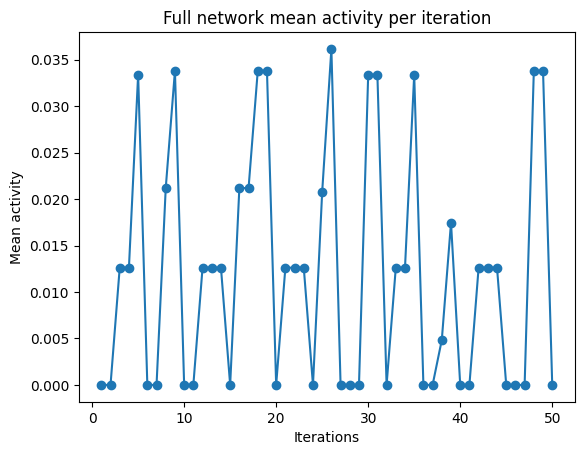

In [69]:
def flatten(l):     # To flatten a list
    return [item for sublist in l for item in sublist]

nb_inputs = 10
nb_outputs = 1
sigmoid_type = False                                 # If the neurons are sigmoid type or not
threshold = 0.7
iterations = 50
min_weight = -1
max_weight = 1

model = Network(nb_inputs, nb_outputs, (min_weight, max_weight))              # Create the network
model.add_layer(16, sigmoid=False, threshold=threshold)
model.add_layer(nb_outputs, sigmoid=False, threshold=threshold)   # We have to manually add the last layer
model.build_weights()                               # Build the weight matrices

x = np.linspace(0, 2*np.pi, nb_inputs)
input_array = 0.5*np.sin(x)
output_array = np.zeros(iterations)
mean_activity = np.zeros(iterations)

for i in range(iterations):
    output_array[i] = model.forward_pass(input_array)
    activity_i = flatten(model.get_activity())
    mean_activity[i] = np.mean(activity_i)
plt.plot(np.arange(iterations)+1, mean_activity, marker="o")
plt.xlabel("Iterations")
plt.ylabel("Mean activity")
plt.title("Full network mean activity per iteration")


In [71]:
np.save("state_full_network_activity.npy", mean_activity)


## Elements
Activity: A neuron is active when it spikes. The activity of the network is defined by the spiking of the laste neuron.
Duration: Total number of time steps where the last neuron spiked.

# Exercises

## Experimental frame
- An input vector is sent to the net. The network being fully connected, all next layer neurons receive the information as a weighted sum of the vector.
- The network iterates this for every layer until the output layer